In [6]:
# Домашняя работа

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
from sklearn.model_selection import train_test_split
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [7]:
data_full = pd.read_csv('data/kobe.csv')

In [8]:
data_full.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [9]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [10]:
# 1. Провести анализ данных.
# Получим первоначальную информацию о данных
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [11]:
data_full.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [12]:
# Как видно в данных только в целевой переменной есть пропуски. 
# Эти данные можно вынести в отдельный датасет.
data_drop = data_full[data_full['shot_made_flag'].isna()]
data_drop.shape

(5000, 25)

In [13]:
data = data_full.dropna()
data.shape

(25697, 25)

In [14]:
# a) посмотрим как распределяется среднее количество бросков в игре 
data['game_date_DT'] =  data["game_date"].apply(lambda x:  datetime.strptime(x, "%Y-%m-%d"))

data_count = data[["game_date_DT", 'shot_made_flag','shot_id']].groupby(["game_date_DT", 'shot_made_flag']).count()
data_count.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


shot_id
game_date_DT shot_made_flag         
2016-04-10   1.0                   9
2016-04-11   0.0                   6
             1.0                   3
2016-04-13   0.0                  24
             1.0                  19

In [15]:
data_count_pivot = data_count.reset_index().pivot(index='game_date_DT', columns='shot_made_flag',values='shot_id').fillna(0).reset_index()
data_count_pivot.head()


shot_made_flag,game_date_DT,0.0,1.0
0,1996-11-03,1.0,0.0
1,1996-11-05,1.0,0.0
2,1996-11-06,1.0,2.0
3,1996-11-08,4.0,2.0
4,1996-11-10,3.0,0.0


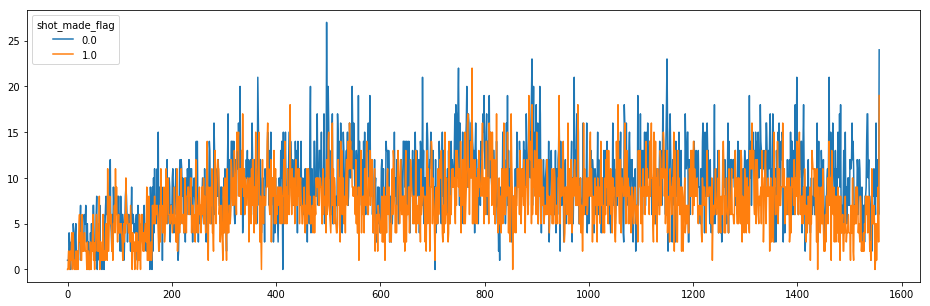

In [16]:
matplotlib.rcParams['figure.figsize'] = (16.0, 5.0)
data_count_pivot[[0.0,1.0]].plot()


<Figure size 1296x720 with 0 Axes>

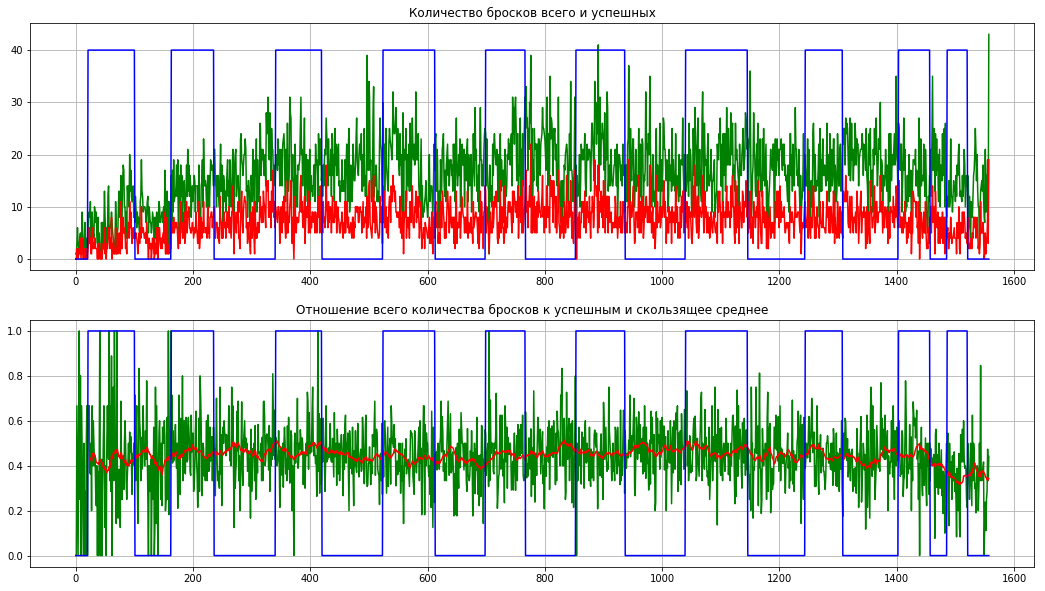

In [17]:
# посмотрим соотношение между числом бросков
window = 25
data_count_pivot['x'] = data_count_pivot[1.0]+data_count_pivot[0.0]
data_count_pivot['x_mean'] = data_count_pivot[1.0].rolling(window=window).mean()/data_count_pivot['x'].rolling(window=window).mean()
year_b = data_count_pivot['game_date_DT'].apply(lambda x : x.year%2)
data_count_pivot['year']= data_count_pivot['game_date_DT'].apply(lambda x : x.year)
plt.figure(figsize=(18,10))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
axes[0].plot(data_count_pivot['x'], "g", label="x")
axes[0].plot(data_count_pivot[1.0],'r', label="x_mean")
axes[0].plot(year_b*40,'b', label="year")
axes[0].set_title('Количество бросков всего и успешных')
axes[0].grid(True)
axes[1].plot(data_count_pivot[1.0]/data_count_pivot['x'],'g', label="x_mean")
axes[1].plot(data_count_pivot['x_mean'],'r', label="x_mean")
axes[1].plot(year_b,'b', label="year")
axes[1].set_title('Отношение всего количества бросков к успешным и скользящее среднее')
axes[1].grid(True)



/home/user/.local/lib/python3.6/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/user/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/user/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, 

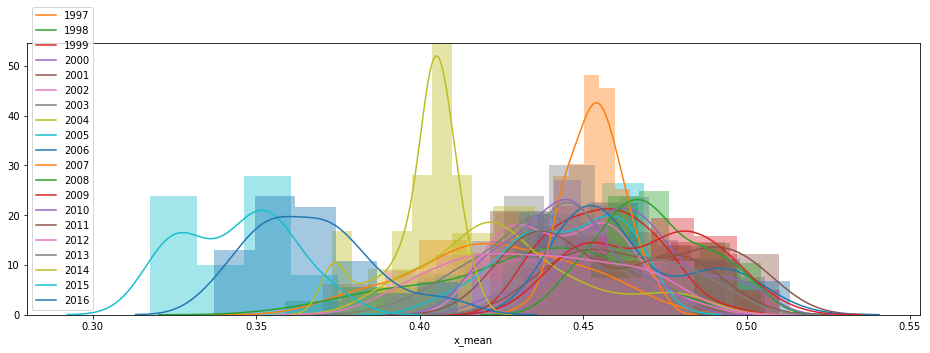

In [18]:
# 
for i in data_count_pivot['year'].unique()[:]:
    sns.distplot(data_count_pivot[data_count_pivot['year'] == i]['x_mean'].dropna(), kde_kws={"label": str(i)},)

/home/user/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


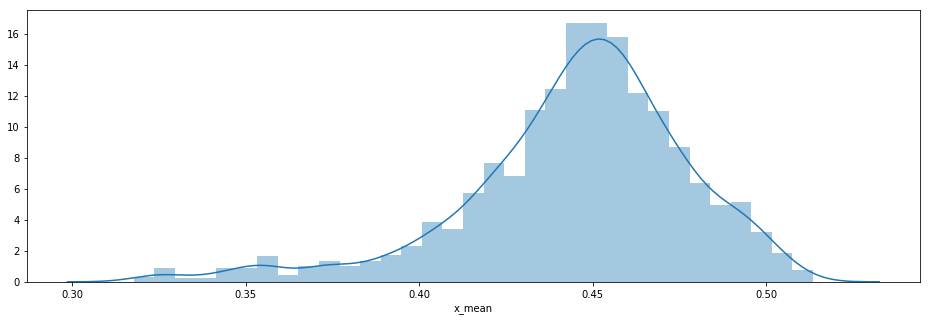

In [19]:
sns.distplot(data_count_pivot['x_mean'].dropna())

In [20]:
#  Исходя из этих графиков можно сделать вывод, что практически в течении 
#  всей карьеры точность бросков хоть и прыгала,
#  но в среднем оставалась примерно на одном уровне
#  однако в сезонах с 2014 по 2016 точность бросков пошла у убыль
#  возможно по этому пока еще игрок на вершине славы он решил уйти из спорта

In [21]:
# 2. Подготовить фичи для обучения модели

In [22]:
#  Посмотрим категориальные переменные

In [23]:
# Кодируем one hot encoding
# combined_shot_type    6 типов
# shot_type             2 типа
# shot_zone_area        6 типов
# shot_zone_basic       7 типов
# shot_zone_range       5 типов

# Удаляем
# team_name             1 тип

# Кодируем WOE 
# action_type           55 типов 
# season                20 типов
# matchup               74 типа
# opponent              33 типа

# Переведем в числовой тип
# game_date             1558 дат

In [24]:
# Заполнить средними значениеми
def put_mean_to_na_param(dataset, list_columns):
    for i in list_columns:
        dataset[i].fillna(dataset[i].mean(), inplace=True)
        
# Заполнить значением
def put_value_to_na_param(dataset, list_columns, value=0 ):
    for i in list_columns:
        dataset[i].fillna(value, inplace=True)
        
# Заполнить самым распространенным значением
def put_most_common_meaning_to_na_param(dataset, list_columns):
    for i in list_columns:
        dataset[i].fillna(dataset[i].value_counts()[0], inplace=True)

In [25]:
# Закодировать nominal категориальную переменную с помощью "one hot encoding"  (используем реализацию из лекций)
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def get_woe_v1(df_train, df_test, col, target_col):
    all_one = df_train[col].value_counts() / df_train[col].value_counts()
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        (((all_one*df_train[df_train[target_col] == 1][col].value_counts()).fillna(0)+0.5)/all_good)
        /
        (((all_one*df_train[df_train[target_col] == 0][col].value_counts()).fillna(0)+0.5)/all_bad)
    )
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test


def get_woe_cols(df_train, df_test, cols, target_col):
    for col in cols:
        df_train, df_test = get_woe_v1(df_train, df_test, col, target_col)
    return df_train, df_test

In [26]:
data = get_one_hot(data, ['combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range']) 

In [27]:
data['year']= data['game_date_DT'].apply(lambda x: x.year)


In [28]:
data.shape

(25697, 53)

In [29]:
data_train_tmp = []
data_test_tmp = []
y_train_tmp = np.array([])
y_test_tmp = np.array([])

In [30]:
for i in data['year'].unique():
    t_tmp = data[data['year'] == i]['shot_made_flag'] 
    data_train, data_test, y_train, y_test = train_test_split(data[data['year'] == i],t_tmp, test_size=0.25)
    data_train_tmp.append(data_train)
    data_test_tmp.append(data_test)
    y_train_tmp =np.append(y_train_tmp, y_train)
    y_test_tmp =np.append(y_test_tmp, y_test)
data_train, data_test, y_train, y_test = pd.concat(data_train_tmp), pd.concat(data_test_tmp), y_train_tmp, y_test_tmp
data_train, data_test = get_woe_cols(data_train, data_test, ['action_type', 'season', 'matchup', 'opponent'], 'shot_made_flag')    


In [31]:
drop_cat_columns=['game_date','team_name','action_type', 'season', 'matchup', 'opponent','combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range']


In [32]:
data_train = data_train.drop(columns=drop_cat_columns)
data_test = data_test.drop(columns=drop_cat_columns)

In [33]:
data_train['days'] = data_train.apply(lambda x : x['game_date_DT'].toordinal(), axis=1)
data_test['days'] = data_test.apply(lambda x : x['game_date_DT'].toordinal(), axis=1)

In [34]:
data_train = data_train.drop(columns=['game_date_DT','shot_made_flag'])
data_test = data_test.drop(columns=['game_date_DT','shot_made_flag'])


In [35]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train = sc.fit_transform(data_train)
test = sc.transform(data_test.fillna(0))

In [36]:
train.shape

(19265, 45)

In [37]:
train = pd.DataFrame(train, columns=data_train.columns.values.tolist())

In [38]:
# 3. Обучить линейную модель, Lasso, Ridge
# 4. Сравнить результаты на тестовом наборе данных - сделать train_test_split 
#    в самом начале, подготовить переменные, сравнить результаты работы классификаторов 
#    (те же 3), метрика ROC AUC

In [59]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score

def regression(model,data, y, data_test, y_test):
    model.fit(data, y)
    y_pred = model.predict(data)
    y_pred_test = model.predict(data_test)
    rss = sum((y_pred-y) ** 2)
    ret = [(model.alpha if  hasattr(model, 'alpha')  else 0), rss]
    ret.extend([roc_auc_score(y_test, y_pred_test)])
    ret.extend([model.intercept_])
    ret.extend(model.coef_)
    x = ['alpha', 'rss','roc_auc_on_test','intercept'] 
    x.extend(data.columns.values.tolist())
    res = pd.DataFrame(np.array(ret).reshape(1,len(data.columns.values.tolist())+4), columns=x)
    return res

In [60]:
coef_matrix_ridge = []
coef_matrix_lasso = []
coef_matrix_liner = []

liner = LinearRegression()
res_liner = regression(liner,train, y_train,test,y_test)

alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
for i in range(10):
    ridgereg = Ridge(alpha=alpha[i], normalize=True)
    lassoreg = Lasso(alpha=alpha[i], normalize=True)
    coef_matrix_ridge.append(regression(ridgereg,train, y_train,test,y_test))
    coef_matrix_lasso.append(regression(lassoreg,train, y_train,test,y_test))
    
res_ridge = pd.concat(coef_matrix_ridge, ignore_index=True)
res_lasso = pd.concat(coef_matrix_lasso, ignore_index=True)

/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [61]:
res_liner

,alpha,rss,roc_auc_on_test,intercept,game_event_id,game_id,lat,loc_x,loc_y,lon,...,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.,year,action_type_woe,season_woe,matchup_woe,opponent_woe,days
0,0.0,4059.771833,0.694968,0.455928,0.003476,0.033882,-1.283134e+11,-1.418330e+11,-1.283134e+11,1.418330e+11,...,8.687636e+11,-8.074264e+11,1.769982e+11,-9.036587e+11,0.057353,0.21669,0.026233,0.020873,0.000803,-0.04919


In [62]:
res_ridge

,alpha,rss,roc_auc_on_test,intercept,game_event_id,game_id,lat,loc_x,loc_y,lon,...,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.,year,action_type_woe,season_woe,matchup_woe,opponent_woe,days
0,1.000000e-15,4058.931135,0.694273,0.446665,0.003476,0.038900,-0.017929,-0.120590,-0.032943,0.114065,...,-0.012025,0.013103,-0.010899,-0.028782,0.022027,0.214776,0.024363,0.024101,-0.002489,-0.012580
1,1.000000e-10,4058.931135,0.694273,0.446665,0.003476,0.038900,0.007504,-0.003264,-0.007510,-0.003261,...,-0.011376,0.014387,-0.008890,-0.027345,0.022027,0.214776,0.024363,0.024101,-0.002489,-0.012580
2,1.000000e-08,4058.931135,0.694273,0.446665,0.003476,0.038900,0.007507,-0.003263,-0.007507,-0.003263,...,-0.011408,0.014367,-0.008926,-0.027367,0.022027,0.214776,0.024363,0.024101,-0.002489,-0.012580
3,1.000000e-04,4058.931286,0.694270,0.446665,0.003387,0.038451,0.007489,-0.003256,-0.007489,-0.003256,...,-0.011326,0.014333,-0.008918,-0.027371,0.021283,0.214714,0.024355,0.024096,-0.002483,-0.011968
4,1.000000e-03,4058.943016,0.694300,0.446665,0.002696,0.034811,0.007334,-0.003193,-0.007334,-0.003193,...,-0.010633,0.014046,-0.008849,-0.027393,0.016392,0.214159,0.024282,0.024049,-0.002433,-0.008151
5,1.000000e-02,4059.445232,0.694504,0.446665,-0.000845,0.017599,0.006048,-0.002638,-0.006048,-0.002638,...,-0.006507,0.012101,-0.008364,-0.026743,0.004900,0.208886,0.023645,0.023641,-0.002020,-0.001637
6,1.000000e+00,4240.484124,0.679684,0.446665,-0.003978,-0.000391,0.003049,0.000583,-0.003049,0.000583,...,-0.003769,0.001574,-0.003987,0.001632,0.000201,0.071478,0.010654,0.010885,0.004532,0.000132
7,5.000000e+00,4444.083250,0.657737,0.446665,-0.001811,-0.000267,0.004348,0.000217,-0.004348,0.000217,...,-0.003527,-0.000270,-0.002017,0.004971,-0.000485,0.024596,0.003795,0.004249,0.002560,-0.000497
8,1.000000e+01,4532.023328,0.651751,0.446665,-0.001125,-0.000146,0.003530,0.000098,-0.003530,0.000098,...,-0.002762,-0.000297,-0.001338,0.004066,-0.000481,0.014207,0.002199,0.002478,0.001576,-0.000485
9,2.000000e+01,4610.405223,0.648156,0.446665,-0.000653,-0.000069,0.002423,0.000037,-0.002423,0.000037,...,-0.001875,-0.000206,-0.000816,0.002775,-0.000360,0.007849,0.001219,0.001364,0.000892,-0.000362


In [63]:
res_lasso

,alpha,rss,roc_auc_on_test,intercept,game_event_id,game_id,lat,loc_x,loc_y,lon,...,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.,year,action_type_woe,season_woe,matchup_woe,opponent_woe,days
0,1.000000e-15,4058.931138,0.694273,0.446665,0.003469,0.038891,0.014930,-0.006524,-0.000084,-1.086628e-06,...,0.008695,0.024470,2.554920e-03,-0.016060,0.021868,0.214776,0.024364,0.024101,-0.002488,-0.012424
1,1.000000e-10,4058.931138,0.694273,0.446665,0.003467,0.038889,0.014930,-0.006524,-0.000084,-1.084813e-06,...,0.008678,0.024459,2.524600e-03,-0.016072,0.021862,0.214776,0.024364,0.024101,-0.002488,-0.012418
2,1.000000e-08,4058.931212,0.694263,0.446665,0.003347,0.038697,0.014904,-0.006511,-0.000070,-9.052860e-07,...,0.007059,0.023358,-3.935960e-05,-0.017285,0.021271,0.214769,0.024363,0.024097,-0.002483,-0.011881
3,1.000000e-04,4116.813504,0.682861,0.446665,-0.000302,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-7.262925e-16,0.000000,-0.000000,0.165602,0.011953,0.010003,0.000000,-0.000000
4,1.000000e-03,4504.664369,0.680738,0.446665,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,0.041740,0.000000,0.000000,0.000000,-0.000000
5,1.000000e-02,4761.448222,0.500000,0.446665,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
6,1.000000e+00,4761.448222,0.500000,0.446665,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
7,5.000000e+00,4761.448222,0.500000,0.446665,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
8,1.000000e+01,4761.448222,0.500000,0.446665,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
9,2.000000e+01,4761.448222,0.500000,0.446665,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000e+00,...,-0.000000,-0.000000,-0.000000e+00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000


In [42]:
# 5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют
#    наибольшую часть дисперсии целевой переменной

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8).fit(train)
train_pca = pca.transform(train)
test_pca = pca.transform(test)
pca.explained_variance_ratio_ * 100

array([18.74139973, 10.24408586,  7.22268464,  6.8310728 ,  5.85590733,
        5.43456494,  4.78496312,  4.42946583,  3.83061771,  3.67151097,
        3.2826175 ,  2.90793229,  2.38972594,  2.30343158])

Text(0,0.5,'explained_variance_ratio_')

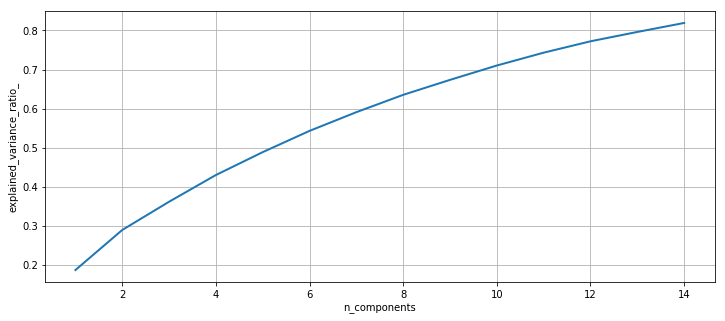

In [66]:
import matplotlib.pyplot as plt
matplotlib.pyplot.figure(figsize=(12, 5))
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [69]:
def regression_pca(model,data, y, data_test, y_test):
    model.fit(data, y)
    y_pred = model.predict(data)
    y_pred_test = model.predict(data_test)
    rss = sum((y_pred-y) ** 2)
    ret = [(model.alpha if  hasattr(model, 'alpha')  else 0), rss]
    ret.extend([roc_auc_score(y_test, y_pred_test)])
    ret.extend([model.intercept_])
    ret.extend(model.coef_)
    return ret

In [70]:
coef_matrix_ridge_pca = []
coef_matrix_lasso_pca = []
coef_matrix_liner_pca = []

liner = LinearRegression()
res_liner_pca = regression_pca(liner,train_pca, y_train,test_pca,y_test)

alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
for i in range(10):
    ridgereg = Ridge(alpha=alpha[i], normalize=True)
    lassoreg = Lasso(alpha=alpha[i], normalize=True)
    coef_matrix_ridge_pca.append(regression_pca(ridgereg,train_pca, y_train,test_pca,y_test))
    coef_matrix_lasso_pca.append(regression_pca(lassoreg,train_pca, y_train,test_pca,y_test))
x=['alpha','rss', 'roc_auc_on_test','intercept']
x.extend(['f'+str(i) for i in range(14)])    
res_ridge_pca = pd.DataFrame(coef_matrix_ridge_pca, columns=x)
res_lasso_pca = pd.DataFrame(coef_matrix_lasso_pca, columns=x)

In [71]:
res_liner_pca

[0,
 4301.601107079118,
 0.6709836216415164,
 0.44666493641318455,
 -0.036873670259539866,
 0.012980632953388957,
 0.0036113551584461456,
 -0.0019457243645906765,
 -0.0062555092725642,
 -0.00552654293253669,
 -0.009225652108457815,
 -0.0001538158390742996,
 0.006749561500851667,
 -0.027847253929648597,
 0.08346078840207138,
 0.0027570221347608848,
 -0.004468117012919611,
 -0.008362151536886086]

In [72]:
res_ridge_pca

,alpha,rss,roc_auc_on_test,intercept,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,1.000000e-15,4301.601107,0.670984,0.446665,-0.036874,0.012981,0.003611,-0.001946,-0.006256,-0.005527,-0.009226,-0.000154,0.006750,-0.027847,0.083461,0.002757,-0.004468,-0.008362
1,1.000000e-10,4301.601107,0.670984,0.446665,-0.036874,0.012981,0.003611,-0.001946,-0.006256,-0.005527,-0.009226,-0.000154,0.006750,-0.027847,0.083461,0.002757,-0.004468,-0.008362
2,1.000000e-08,4301.601107,0.670984,0.446665,-0.036874,0.012981,0.003611,-0.001946,-0.006256,-0.005527,-0.009226,-0.000154,0.006750,-0.027847,0.083461,0.002757,-0.004468,-0.008362
3,1.000000e-04,4301.601112,0.670984,0.446665,-0.036870,0.012979,0.003611,-0.001946,-0.006255,-0.005526,-0.009225,-0.000154,0.006749,-0.027844,0.083452,0.002757,-0.004468,-0.008361
4,1.000000e-03,4301.601566,0.670984,0.446665,-0.036837,0.012968,0.003608,-0.001944,-0.006249,-0.005521,-0.009216,-0.000154,0.006743,-0.027819,0.083377,0.002754,-0.004464,-0.008354
5,1.000000e-02,4301.646186,0.670984,0.446665,-0.036509,0.012852,0.003576,-0.001926,-0.006194,-0.005472,-0.009134,-0.000152,0.006683,-0.027572,0.082634,0.002730,-0.004424,-0.008279
6,1.000000e+00,4416.562886,0.670984,0.446665,-0.018437,0.006490,0.001806,-0.000973,-0.003128,-0.002763,-0.004613,-0.000077,0.003375,-0.013924,0.041730,0.001379,-0.002234,-0.004181
7,5.000000e+00,4620.939381,0.670984,0.446665,-0.006146,0.002163,0.000602,-0.000324,-0.001043,-0.000921,-0.001538,-0.000026,0.001125,-0.004641,0.013910,0.000460,-0.000745,-0.001394
8,1.000000e+01,4681.640045,0.670984,0.446665,-0.003352,0.001180,0.000328,-0.000177,-0.000569,-0.000502,-0.000839,-0.000014,0.000614,-0.002532,0.007587,0.000251,-0.000406,-0.000760
9,2.000000e+01,4718.695996,0.670984,0.446665,-0.001756,0.000618,0.000172,-0.000093,-0.000298,-0.000263,-0.000439,-0.000007,0.000321,-0.001326,0.003974,0.000131,-0.000213,-0.000398


In [73]:
res_lasso_pca

,alpha,rss,roc_auc_on_test,intercept,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,1.000000e-15,4301.601107,0.670984,0.446665,-0.036874,0.012981,0.003611,-0.001946,-0.006256,-0.005527,-0.009226,-0.000154,0.006750,-0.027847,0.083461,0.002757,-0.004468,-0.008362
1,1.000000e-10,4301.601107,0.670984,0.446665,-0.036874,0.012981,0.003611,-0.001946,-0.006256,-0.005527,-0.009226,-0.000154,0.006750,-0.027847,0.083461,0.002757,-0.004468,-0.008362
2,1.000000e-08,4301.601108,0.670985,0.446665,-0.036873,0.012980,0.003611,-0.001945,-0.006255,-0.005526,-0.009225,-0.000153,0.006748,-0.027846,0.083460,0.002756,-0.004467,-0.008361
3,1.000000e-04,4327.703230,0.669576,0.446665,-0.032040,0.006443,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.016927,0.071912,0.000000,-0.000000,-0.000000
4,1.000000e-03,4761.448222,0.500000,0.446665,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
5,1.000000e-02,4761.448222,0.500000,0.446665,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
6,1.000000e+00,4761.448222,0.500000,0.446665,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
7,5.000000e+00,4761.448222,0.500000,0.446665,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
8,1.000000e+01,4761.448222,0.500000,0.446665,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
9,2.000000e+01,4761.448222,0.500000,0.446665,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
